## Reference
__Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.__

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 has 10 classes with these names (provided by Keras)
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The data loaded by cifar10.load_data() is already in the shape (num_images, 32, 32, 3),
# so the reshaping step is not needed.

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Training Set: {x_train.shape}, Test Set: {x_test.shape}")
print(f"Classes: {label_names}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training Set: (50000, 32, 32, 3), Test Set: (10000, 32, 32, 3)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# Split the original training set (50,000 images) into Train (80%) and Validation (20%)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print dataset shapes
print(f"New Training Set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Validation Set: {x_val.shape}, Labels: {y_val.shape}")
print(f"Test Set (unchanged): {x_test.shape}, Labels: {y_test.shape}")

New Training Set: (40000, 32, 32, 3), Labels: (40000, 1)
Validation Set: (10000, 32, 32, 3), Labels: (10000, 1)
Test Set (unchanged): (10000, 32, 32, 3), Labels: (10000, 1)


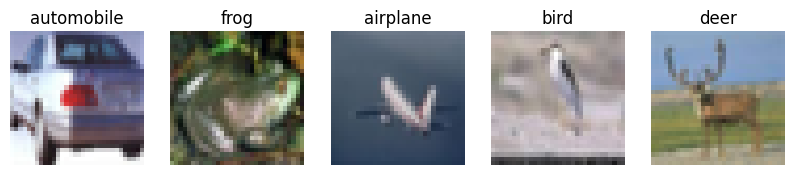

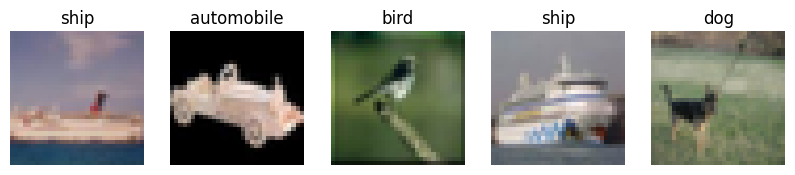

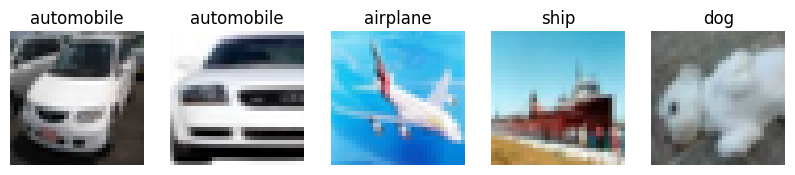

In [5]:
def show_images(images, labels, title, num_images=5):
    plt.figure(figsize=(10, 2))  # Set figure size
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        index = np.random.randint(0, len(images))  # Pick a random index
        plt.imshow(images[index])
        plt.title(label_names[labels[index][0]])
        plt.axis("off")  # Hide axes
    plt.show()

# Show images from each dataset
show_images(x_train, y_train, "Training Set")
show_images(x_val, y_val, "Validation Set")
show_images(x_test, y_test, "Test Set")

In [6]:
# One-hot encode labels for training, validation, and test sets
y_train_cat = to_categorical(y_train, num_classes=10)
y_val_cat = to_categorical(y_val, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

## Models

### Model 1

In [28]:
model = Sequential([

    layers.Input(shape=(32, 32, 3)),
    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [30]:
model.compile(optimizer=Adam(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


In [31]:
# Implement Learning Rate Scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Implement Early Stopping with patience of 3 (you can adjust this)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [32]:
history = model.fit(
    x_train, y_train_cat,
    epochs=100,
    batch_size=64,
    validation_data=(x_val, y_val_cat),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.3464 - loss: 2.2829 - val_accuracy: 0.5646 - val_loss: 1.3579 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5707 - loss: 1.3586 - val_accuracy: 0.6419 - val_loss: 1.1485 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6568 - loss: 1.1324 - val_accuracy: 0.6915 - val_loss: 1.0251 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6993 - loss: 1.0123 - val_accuracy: 0.7319 - val_loss: 0.9603 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7340 - loss: 0.9275 - val_accuracy: 0.7346 - val_loss: 0.9536 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7614 - loss: 0.8699 - val_accuracy: 0.6845 - val_loss: 1.1881 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7734 - l

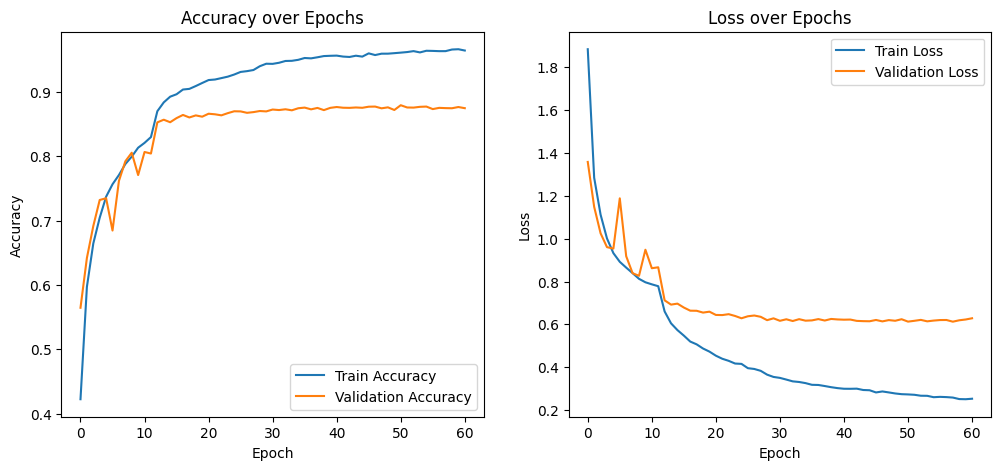

In [33]:
# Evaluate the model
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [34]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8711 - loss: 0.6348
Test Accuracy: 0.8682


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.90      0.89      1000
  automobile       0.93      0.94      0.93      1000
        bird       0.86      0.79      0.82      1000
         cat       0.76      0.72      0.74      1000
        deer       0.87      0.85      0.86      1000
         dog       0.78      0.81      0.80      1000
        frog       0.88      0.93      0.90      1000
       horse       0.89      0.91      0.90      1000
        ship       0.93      0.91      0.92      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



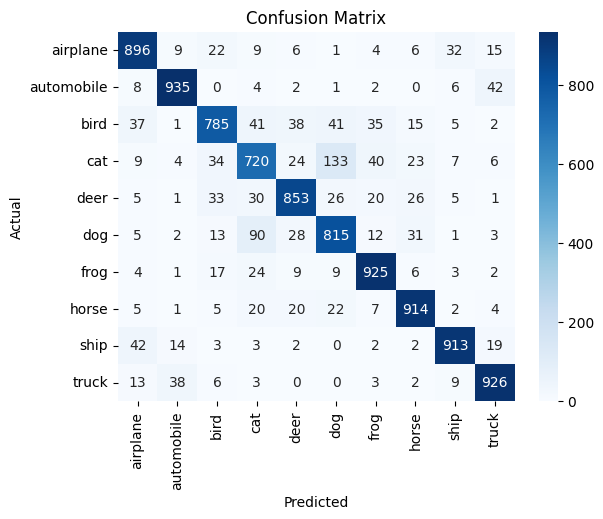

In [35]:
# Generate predictions for the test set
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_names))

# Confusion Matrix
conf_mat_5 = sns.heatmap(
    pd.DataFrame(confusion_matrix(y_test, y_pred_classes),
                 index=label_names, columns=label_names),
    annot=True, fmt='d', cmap='Blues'
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()